In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.activations import sigmoid, linear, relu
from tensorflow.math import add, subtract
from tensorflow.linalg import matmul

tf.__version__

2022-03-12 19:10:52.996807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-12 19:10:52.996835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.8.0'

## Differential equation
$$\frac{d\psi}{dx} + \left(x+\frac{1+3x^2}{1+x+x^3} \right)\psi = x^3+2x+x^2\left(\frac{1+3x^2}{1+x+x^3} \right)$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples

In [2]:
def analytic_sol(x):
    psi = tf.pow(x,2) + tf.exp(-0.5*tf.pow(x,2))/(1+x+tf.pow(x,3))
    return psi

In [3]:
n_h = 10
X_train = tf.constant(np.linspace(0,1,10), dtype=tf.float32)
X_train = tf.reshape(X_train, (1, tf.shape(X_train)[0]))
Y_train = analytic_sol(X_train)
print("Train data x:\n",X_train)
print("Train data y:\n",Y_train)
print(type(X_train))
print(type(Y_train))
shapes = [tf.shape(X_train)[0],n_h,tf.shape(X_train)[0]]

Train data x:
 tf.Tensor(
[[0.         0.11111111 0.22222222 0.33333334 0.44444445 0.5555556
  0.6666667  0.7777778  0.8888889  1.        ]], shape=(1, 10), dtype=float32)
Train data y:
 tf.Tensor(
[[1.         0.90570426 0.8405067  0.80140585 0.7887944  0.8048698
  0.8523673  0.93362933 1.0500929  1.2021769 ]], shape=(1, 10), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


2022-03-12 19:10:55.201796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-12 19:10:55.201826: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-12 19:10:55.201846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (littlerocket): /proc/driver/nvidia/version does not exist
2022-03-12 19:10:55.202172: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Implementation Neural Network model

Neural Network with one hidden layer with 10 hidden units and sigmoid activation, and one linear output unit.

### Initialize random parameters and compute forward propagation

In [4]:
def initialize_parameters(shapes):
    '''
        Initialize parameters for Neural Network
        
        Input: 
        shape -- list of sizes for parameters
        
        Return:
        parameters --  dictionary of tensors W1,b1,W2,b2,..... 
    '''
    n_x, n_h, n_y = shapes
    
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    
    W1 = tf.Variable(initializer(shape=(n_h,n_x)))
    b1 = tf.Variable(initializer(shape=(n_h,1)))
    W2 = tf.Variable(initializer(shape=(n_y,n_h)))
    b2 = tf.Variable(initializer(shape=(n_y,1)))
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

In [5]:
def forward_propagation(X, parameters):
    '''
        Forward propagation for model LINEAR -> SIGMOID -> LINEAR -> LINEAR
        
        Inputs:
        X -- input dataset with discrete points of domain of differential equation
        
        Return:
        N -- single output feedforward neural network
    '''
    
    cache = []
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = add(tf.linalg.matmul(W1,X),b1)
    A1 = sigmoid(Z1)
    #Z2 = add(tf.linalg.matmul(W2,A1),b2) # its posible compute with bias term b2
    Z2 = tf.linalg.matmul(W2,A1)
    A2 = linear(Z2)
    
    cache.append(A1)
    
    return A2, cache

#### Test latest function

In [6]:
parameters = initialize_parameters([1,5,1])
print(parameters["W1"].shape)
print(parameters["b1"].shape)
print(parameters["W2"].shape)
print(parameters["b2"].shape)

(5, 1)
(5, 1)
(1, 5)
(1, 1)


In [7]:
X_test = tf.Variable(np.arange(5), dtype=tf.float32)
X_test = tf.reshape(X_test, (1,5))
N, cache = forward_propagation(X_test, parameters)
N

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.00942882, -0.21110968, -0.37214005, -0.4682066 , -0.5210639 ]],
      dtype=float32)>

### Cost function

In [8]:
def compute_cost(X, N, cache, parameters):
    '''
        Compute the cost function of differential equation
        
        Inputs:
        N -- output of forward propagation
        
        Return:
        cost -- tensor of the cost function
    '''
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    A1 = cache[0]
    
    psi = 1 + tf.multiply(X, N)
    dN_dx = tf.multiply(matmul(W2, W1), tf.multiply(A1, 1-A1)) 
    dpsi_dx = N + tf.multiply(X, dN_dx)
    coeff_1 = tf.multiply(X + (1+3*tf.square(X))/(1+X+tf.pow(X,3)), psi)
    coeff_2 = tf.pow(X,3) + 2*X + tf.multiply(tf.square(X), (1+3*tf.square(X))/(1+X+tf.pow(X,3)))
    
    cost = tf.reduce_sum(tf.square(dpsi_dx + coeff_1 - coeff_2))
    
    return cost

#### Test cost function

In [9]:
cost = compute_cost(X_test, N, cache, parameters)
cost

<tf.Tensor: shape=(), dtype=float32, numpy=51042.594>

## Neural Network model

In [10]:
def model(X_train, shape, learning_rate=0.001, num_epochs = 1000, print_cost = False):
    '''
        Model definition of newral network for LINEAR -> SIGMOID -> LINEAR -> LINEAR
        
        Inputs:
        X_train -- input dataset of points of domain
        Y_train -- input dataset of points of analytic solution
        X_test -- input dataset to test different points over domain
        Y_test -- input dataset to test different points of analytic solution
        num_epochs -- number of iterations to optimize
        print_cost -- boolean variable to get cost
        
        Return:
        parameters -- parameters learned by model 
    '''
    
    costs = []
    
    parameters = initialize_parameters(shape)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    for epoch in range(num_epochs):
        
        with tf.GradientTape() as tape:
            N, cache = forward_propagation(X_train, parameters)
            cost = compute_cost(X_train, N, cache, parameters)
        
        trainable_variables = [W1, b1, W2]
        grads = tape.gradient(cost, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
        
    
        if print_cost == True and epoch % 1000 == 0:
            print ("Cost after epoch %i: %f" % (epoch, cost))
            costs.append(cost)
            

    return parameters, costs, cache

In [11]:
parameters, costs, cache = model(X_train, shape=shapes, learning_rate=0.005, num_epochs=10001, print_cost=True)

Cost after epoch 0: 120.802139
Cost after epoch 1000: 0.351564
Cost after epoch 2000: 0.181621
Cost after epoch 3000: 0.113181
Cost after epoch 4000: 0.094784
Cost after epoch 5000: 0.086960
Cost after epoch 6000: 0.079397
Cost after epoch 7000: 0.072399
Cost after epoch 8000: 0.066100
Cost after epoch 9000: 0.062746
Cost after epoch 10000: 0.060311


In [12]:
parameters

{'W1': <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32, numpy=
 array([[-0.13181522],
        [-0.5054445 ],
        [-0.34129536],
        [-0.36788636],
        [-0.8829125 ],
        [ 0.2465132 ],
        [-0.3858076 ],
        [ 1.2870218 ],
        [-1.5493437 ],
        [-0.24125184]], dtype=float32)>,
 'b1': <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32, numpy=
 array([[ 0.47672904],
        [ 0.75857055],
        [ 0.641521  ],
        [ 0.6610822 ],
        [ 1.0087105 ],
        [-0.56769687],
        [ 0.6741536 ],
        [-1.2496842 ],
        [ 1.4450365 ],
        [ 0.56550497]], dtype=float32)>,
 'W2': <tf.Variable 'Variable:0' shape=(1, 10) dtype=float32, numpy=
 array([[ 0.85715806, -0.30422735,  0.3965073 ,  0.28182265, -1.083401  ,
         -0.43225503,  0.20221585,  1.3340088 , -2.080591  ,  0.74217296]],
       dtype=float32)>,
 'b2': <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-1.2887479]], dtype=float32)>}

tf.Tensor(
[[1.         0.9041166  0.8323665  0.7877404  0.77295685 0.79028916
  0.8413961  0.9271745  1.0476539  1.2019528 ]], shape=(1, 10), dtype=float32)


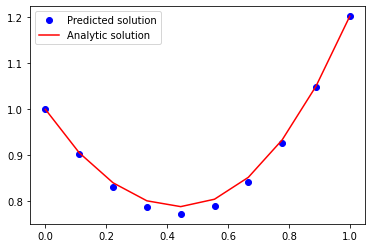

In [13]:
sol = 1 + tf.multiply(X_train, forward_propagation(X_train, parameters)[0])
print(sol)
plt.plot(X_train.numpy()[0], sol.numpy()[0], "ob", label="Predicted solution")
plt.plot(X_train.numpy()[0], Y_train.numpy()[0], "-r", label="Analytic solution")
plt.legend()
plt.show()

In [14]:
error = tf.abs(Y_train - sol)
error

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.        , 0.00158769, 0.00814015, 0.01366544, 0.01583755,
        0.01458061, 0.01097119, 0.00645483, 0.00243902, 0.00022411]],
      dtype=float32)>

In [15]:
from sklearn.metrics import r2_score

r2_score(np.squeeze(Y_train.numpy()), np.squeeze(sol.numpy()))

0.9944118141580823

In [18]:
import tensorflow_probability as tfp 

minimum = np.array([1.0, 1.0])  # The center of the quadratic bowl.
scales = np.array([2.0, 3.0])  # The scales along the two axes.

# The objective function and the gradient.
def quadratic_loss_and_gradient(x):
    return tfp.math.value_and_gradient(
        lambda x: tf.reduce_sum(
            scales * tf.math.squared_difference(x, minimum), axis=-1),
        x)

start = tf.constant([0.6, 0.8])  # Starting point for the search.
optim_results = tfp.optimizer.bfgs_minimize(
    quadratic_loss_and_gradient, initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged) 
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print ("Function evaluations: %d" % optim_results.num_objective_evaluations)

print(optim_results.position)

Function evaluations: 5
tf.Tensor([1. 1.], shape=(2,), dtype=float32)
